In [1]:
import os
import csv

import pandas as pd
import numpy as np

from lib.stats import *


import matplotlib.pyplot as plt
import seaborn as sns
from mrcnn import visualize

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

from library_dicom.dicom_processor.tools.folders import * 

In [97]:
csv_pred_path = '/media/oncopole/DD 2To/SEGMENTATION/inference/prediction_dataset.csv'
df = pd.read_csv(csv_pred_path)

In [98]:
df.head()

,patient_id,study_id,study,ct_img,pet_img,mask_img,pred_img
0,53011101841003,1.2.250.1.199.10.90001.93080.20120515093605,ahl,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DD 2To/SEGMENTATION/inference/...
1,53011101881011,1.2.250.1.199.10.90001.97031.20130222102728,ahl,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DD 2To/SEGMENTATION/inference/...
2,53011101841011,1.2.250.1.199.10.90001.97274.20140120115149,ahl,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DDArchive/AHL_NIFTI/5301110184...,/media/oncopole/DD 2To/SEGMENTATION/inference/...
3,53011101881007,1.2.250.1.199.10.90001.98250.20120824131623,ahl,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DDArchive/AHL_NIFTI/5301110188...,/media/oncopole/DD 2To/SEGMENTATION/inference/...
4,53011101871009,1.2.250.1.38.2.1.102.130708113824.102392945,ahl,/media/oncopole/DDArchive/AHL_NIFTI/5301110187...,/media/oncopole/DDArchive/AHL_NIFTI/5301110187...,/media/oncopole/DDArchive/AHL_NIFTI/5301110187...,/media/oncopole/DD 2To/SEGMENTATION/inference/...


In [100]:
study = []
number = []
for idx,name in enumerate(df['study'].value_counts().index.tolist()):
    #print('Study:', name)
    study.append(name)
    #print('Number :', df['study'].value_counts()[idx])
    number.append(df['study'].value_counts()[idx])
print(study)
print(number)

percent = []
for s, n in zip(study, number):
    print(s)
    print("{} % ".format(round(n/np.sum(number)*100,2)))
    print('')
    percent.append(round(n/np.sum(number)*100,2))

['ahl', 'gained', 'pvab', 'relevance', 'remarc', 'flip', 'lnh073b']
[109, 89, 74, 44, 28, 18, 7]
ahl
29.54 % 

gained
24.12 % 

pvab
20.05 % 

relevance
11.92 % 

remarc
7.59 % 

flip
4.88 % 

lnh073b
1.9 % 



In [ ]:
dataset = df.values.tolist()
print("NUMBER OF INFERENCE : ", len(dataset))

In [ ]:
#DICE 
seuil = [0.41, 2.5, 4.0]
for inference in dataset[361:] :
    print(dataset.index(inference)) 
    pet_array, spacing = get_array_from_nifti(inference[4])
    for s in seuil : 
        if s == 0.41 : 
            #Watershed
            ws_array = applied_watershed_on_inference(inference[6], inference[4])
            pred_array = np.transpose(ws_array, (2,1,0))
            true_array, _ = get_array_from_nifti(inference[5]) 
            dice = calcul_dice(pred_array, true_array, pet_array, thresh = s)
            inference.append(dice[0])
            filename = inference[1]+'_'+str(s)
            write_json_file('/media/oncopole/DD 2To/SEGMENTATION/inference/stats/dice', filename, inference)
            print(dice)
            
        else : 
            
            pred_array, _ = get_array_from_nifti(inference[6])
            true_array, _ = get_array_from_nifti(inference[5])
            dice = calcul_dice(pred_array, true_array, pet_array, thresh = s)
            inference.append(dice[0])
            filename = inference[1]+'_'+str(s)
            write_json_file('/media/oncopole/DD 2To/SEGMENTATION/inference/stats/dice', filename, inference)
            print(dice)
           

In [ ]:
#TMTV
seuil = [0.41, 2.5, 4.0]
for inference in dataset[361:] : 
    print(dataset.index(inference))
    pet_array, spacing = get_array_from_nifti(inference[4])
    for s in seuil : 
        if s == 0.41 : 
            #Watershed
            ws_array = applied_watershed_on_inference(inference[6], inference[4])
            pred_array = np.transpose(ws_array, (2,1,0))
            true_array, _ = get_array_from_nifti(inference[5]) 
            tmtv_pred, tmtv_true = calcul_tmtv(pred_array, true_array, pet_array, spacing, thresh = s)
            inference.append(tmtv_pred)
            inference.append(tmtv_true)
            filename = inference[1]+'_'+str(s)
            write_json_file('/media/oncopole/DD 2To/SEGMENTATION/inference/stats/tmtv', filename, inference)
            #print("tmtv_pred :", tmtv_pred)
            #print("tmtv_true :", tmtv_true)
            
        else : 
            
            pred_array, _ = get_array_from_nifti(inference[6])
            true_array, _ = get_array_from_nifti(inference[5])
            tmtv_pred, tmtv_true = calcul_tmtv(pred_array, true_array, pet_array, spacing, thresh = s)
            inference.append(tmtv_pred)
            inference.append(tmtv_true)
            filename = inference[1]+'_'+str(s)
            write_json_file('/media/oncopole/DD 2To/SEGMENTATION/inference/stats/tmtv', filename, inference)
            #print("tmtv_pred :", tmtv_pred)
            #print("tmtv_true :", tmtv_true)
           


In [ ]:
#csv_dice 

directory = '/media/oncopole/DD 2To/SEGMENTATION/inference/stats/dice'
liste_json = os.listdir(directory)
full_liste = []
for json_file in liste_json : 
    if '_4.0' in json_file : 
        full_liste.append(os.path.join(directory, json_file))

print(len(full_liste)) #must be 369
dataset = []
for json_file in full_liste : 
    with open(json_file) as json_file : 
        reader = json.load(json_file)
        dataset.append(reader)
print(dataset[0])
filename = 'inference_dice_dataset.csv'

with open(os.path.join(directory, filename), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["patient_id", "study_uid", "study", "ct_img", "pet_img", "mask_img", "pred_img", "dice_0.41", "dice_2.5", "dice_4.0"])
    for serie in dataset: 
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], serie[8], serie[9]])

In [ ]:
#csv_tmtv

directory = '/media/oncopole/DD 2To/SEGMENTATION/inference/stats/tmtv'
liste_json = os.listdir(directory)
full_liste = []
for json_file in liste_json : 
    if '_4.0' in json_file : 
        full_liste.append(os.path.join(directory, json_file))

print(len(full_liste)) #must be 369
dataset = []
for json_file in full_liste : 
    with open(json_file) as json_file : 
        reader = json.load(json_file)
        dataset.append(reader)
filename = 'inference_tmtv_dataset.csv'

with open(os.path.join(directory, filename), 'w') as csv_file : 
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["patient_id", "study_uid", "study", "ct_img", "pet_img", "mask_img", "pred_img", "pred_0.41", "true_0.41", "pred_2.5", "true_2.5", "pred_4.0", "true_4.0"])
    for serie in dataset: 
        csv_writer.writerow([serie[0], serie[1], serie[2], serie[3], serie[4], serie[5], serie[6], serie[7], serie[8], serie[9], serie[10], serie[11], serie[12]])

In [90]:
#STATS ON DICE 
csv_path= '/media/oncopole/DD 2To/SEGMENTATION/inference/stats/dice/inference_dice_dataset.csv'
with open(csv_path, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    dataset = []
    for row in reader :
        dataset.append(row)
        
del dataset[0] #enlever première ligne

dice_0_41 = []
dice_2_5 = []
dice_4_0 = []
small_dice = []
for row in dataset : 
    #if row[-3] <= '0.4' or row[-2] <= '0.4' or row[-1] <= '0.4' : 
     #   small_dice.append(row)
    #else : 
    dice_0_41.append(float(row[-3]))
    dice_2_5.append(float(row[-2]))
    dice_4_0.append(float(row[-1]))
print(len(dice_0_41))
print(len(dice_2_5))
print(len(dice_4_0))


369
369
369


In [ ]:
#287/369 qui ont un dice plus grand que 0.5 sur une des trois segmentation
#21/369 qui ont un dice plus grand que 0.3 sur une des trois segmentation
#336/369 qui ont un dice plus grand que 0.3 sur une des trois segmentation

In [92]:
print('stats on 0.41 segmentation : ')
print("dice max : ", np.max(dice_0_41))
print("dice min :", np.min(dice_0_41))
print('dice mean :', np.mean(dice_0_41))
print('dice median :' , np.median(dice_0_41))
print('')
print('')
print('stats on 2.5 segmentation : ')
print("dice max : ", np.max(dice_2_5))
print("dice min :", np.min(dice_2_5))
print('dice mean :', np.mean(dice_2_5))
print('dice median :' , np.median(dice_2_5))
print('')
print('')
print('stats on 4.0 segmentation : ')
print("dice max : ", np.max(dice_4_0))
print("dice min :", np.min(dice_4_0))
print('dice mean :', np.mean(dice_4_0))
print('dice median :' , np.median(dice_4_0))


#dice moyen : 
print('')
print('')
print('mean dice on every segmentation :', (np.mean(dice_0_41)+np.mean(dice_2_5)+np.mean(dice_4_0)) / 3)
print('mean of median dice on every segmentation :', (np.median(dice_0_41)+ np.median(dice_2_5)+np.median(dice_4_0)) / 3)

stats on 0.41 segmentation : 
dice max :  1.0
dice min : 0.0
dice mean : 0.673407435829251
dice median : 0.7306772908366533


stats on 2.5 segmentation : 
dice max :  0.9828178694158075
dice min : 0.0
dice mean : 0.6891006887191443
dice median : 0.7287984553690777


stats on 4.0 segmentation : 
dice max :  1.0
dice min : 0.0
dice mean : 0.8364955186547467
dice median : 0.8865006553079947


mean dice on every segmentation : 0.7330012144010473
mean of median dice on every segmentation : 0.7819921338379086


In [93]:
#STATS ON TMTV 
csv_path= '/media/oncopole/DD 2To/SEGMENTATION/inference/stats/tmtv/inference_tmtv_dataset.csv'
with open(csv_path, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    dataset = []
    for row in reader :
        dataset.append(row)
        
del dataset[0] #enlever première ligne


tmtv_0_41_pred = []
tmtv_2_5_pred = []
tmtv_4_0_pred = []
tmtv_0_41_true = []
tmtv_2_5_true = []
tmtv_4_0_true = []

for row in dataset : 
    tmtv_0_41_pred.append(float(row[-6]))#pred 0.41
    tmtv_0_41_true.append(float(row[-5]))#true 0.41
    tmtv_2_5_pred.append(float(row[-4]))#pred 2.5
    tmtv_2_5_true.append(float(row[-3]))#true 2.5
    tmtv_4_0_pred.append(float(row[-2])) #pred 4.0
    tmtv_4_0_true.append(float(row[-1]))#true 4.0

print(len(tmtv_0_41_pred))
print(len(tmtv_0_41_true))
print(len(tmtv_2_5_pred))
print(len(tmtv_2_5_true))
print(len(tmtv_4_0_pred))
print(len(tmtv_4_0_true))

369
369
369
369
369
369


In [94]:
print('stats on tmtv 0.41 : ')
stats_0_41 = []
maxi = calcul_max_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
mini = calcul_min_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
mean_ = calcul_mean_on_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
median_ = calcul_median_on_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
sd = calcul_sd_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
q1 = calcul_q1_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
q3 =  calcul_q3_tmtv(tmtv_0_41_pred, tmtv_0_41_true)
stats_0_41.append(maxi)
stats_0_41.append(mini)
stats_0_41.append(mean_)
stats_0_41.append(median_)
stats_0_41.append(sd)
stats_0_41.append(q1)
stats_0_41.append(q3)
print('max :', maxi)
print('min :', mini)
print('mean :', mean_)
print('median :', median_)
print('sd :', sd)
print('q1 : ', q1)
print('q3 :', q3)
print('')
print('')

print('stats on tmtv 2.5 : ')
stats_2_5 = []
maxi = calcul_max_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
mini = calcul_min_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
mean_ = calcul_mean_on_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
median_ = calcul_median_on_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
sd = calcul_sd_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
q1 = calcul_q1_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
q3 =  calcul_q3_tmtv(tmtv_2_5_pred, tmtv_2_5_true)
stats_2_5.append(maxi)
stats_2_5.append(mini)
stats_2_5.append(mean_)
stats_2_5.append(median_)
stats_2_5.append(sd)
stats_2_5.append(q1)
stats_2_5.append(q3)
print('max :', maxi)
print('min :', mini)
print('mean :', mean_)
print('median :', median_)
print('sd :', sd)
print('q1 : ', q1)
print('q3 :', q3)
print('')
print('')

print('stats on tmtv 4.0 : ')
stats_4_0 = []
maxi = calcul_max_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
mini = calcul_min_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
mean_ = calcul_mean_on_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
median_ = calcul_median_on_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
sd = calcul_sd_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
q1 = calcul_q1_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
q3 =  calcul_q3_tmtv(tmtv_4_0_pred, tmtv_4_0_true)
stats_4_0.append(maxi)
stats_4_0.append(mini)
stats_4_0.append(mean_)
stats_4_0.append(median_)
stats_4_0.append(sd)
stats_4_0.append(q1)
stats_4_0.append(q3)
print('max :', maxi)
print('min :', mini)
print('mean :', mean_)
print('median :', median_)
print('sd :', sd)
print('q1 : ', q1)
print('q3 :', q3)

stats on tmtv 0.41 : 
max : (4134.08, 3828.544)
min : (0.0, 2.273771654217853)
mean : (323.1955133674703, 379.37008675667914)
median : (187.41886830783884, 233.171615766405)
sd : (424.9973013557296, 464.9294966234)
q1 :  (70.3359958076477, 108.41599353790284)
q3 : (377.7293804395876, 421.01449339388637)


stats on tmtv 2.5 : 
max : (4447.424, 3960.5545366142246)
min : (0.0, 2.730376197723672)
mean : (418.23217871531494, 602.573314790704)
median : (268.1828289632904, 401.49898538379915)
sd : (503.66407790165306, 647.7229716527846)
q1 :  (116.26552379144269, 191.168)
q3 : (527.0260406270972, 746.4816789954784)


stats on tmtv 4.0 : 
max : (3128.896, 3221.8601324841334)
min : (0.0, 0.0)
mean : (322.23732397903433, 372.0079233521646)
median : (187.904, 225.27922814182276)
sd : (425.75953252994947, 475.0805685396451)
q1 :  (70.61488543927507, 82.496)
q3 : (367.104, 457.536)


In [ ]:
#BOXPLOT

738


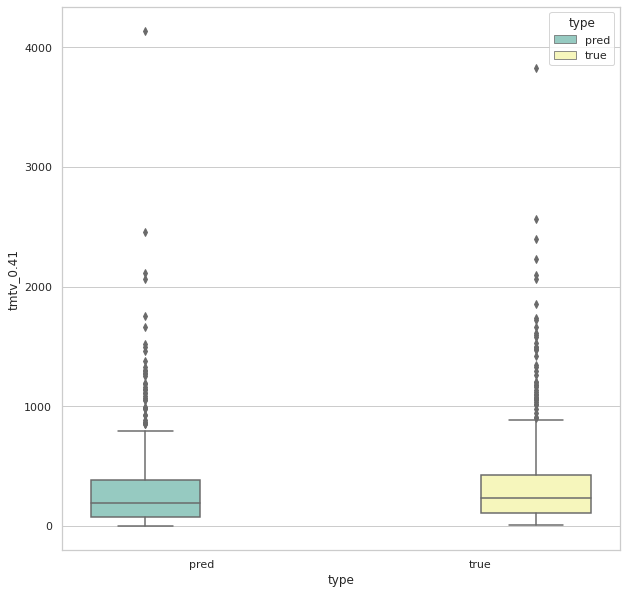

In [81]:
import pandas as pd 
type_ = []
for i in range(369):
    type_.append('pred')
for i in range(369):
    type_.append('true')
print(len(type_))

df = pd.DataFrame([tmtv_0_41_pred+ tmtv_0_41_true, type_]).transpose()
df.columns = ['tmtv_0.41', 'type']
df
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10,10)
ax = sns.boxplot(x="type", y="tmtv_0.41", hue="type",
                 data=df, palette="Set3")

738


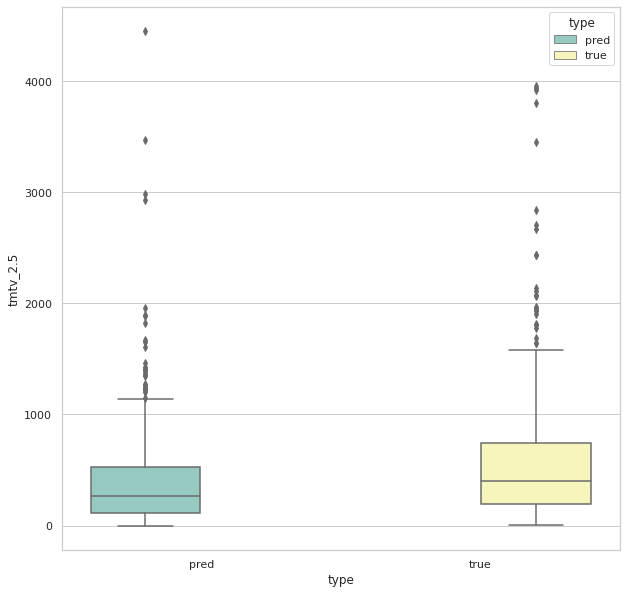

In [82]:
type_ = []
for i in range(369):
    type_.append('pred')
for i in range(369):
    type_.append('true')
print(len(type_))

df = pd.DataFrame([tmtv_2_5_pred+ tmtv_2_5_true, type_]).transpose()
df.columns = ['tmtv_2.5', 'type']
df
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10,10)
ax = sns.boxplot(x="type", y="tmtv_2.5", hue="type",
                 data=df, palette="Set3")

738


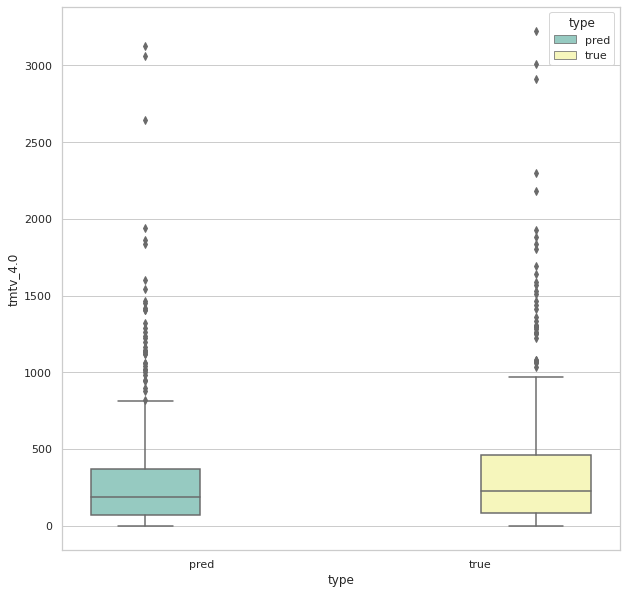

In [83]:
type_ = []
for i in range(369):
    type_.append('pred')
for i in range(369):
    type_.append('true')
print(len(type_))

df = pd.DataFrame([tmtv_4_0_pred+ tmtv_4_0_true, type_]).transpose()
df.columns = ['tmtv_4.0', 'type']
df
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10,10)
ax = sns.boxplot(x="type", y="tmtv_4.0", hue="type",
                 data=df, palette="Set3")

(0.9186324239138469, 4.4954326756122654e-150)


Text(0.5, 1.0, 'Corrélation tmtv pred/manual on 0.41 segmentation')

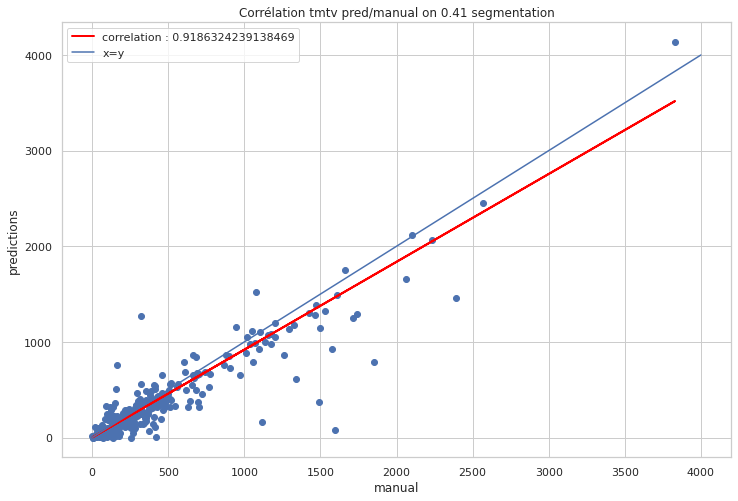

In [85]:
#correlation 
#0.41 
import scipy.stats as ss 


correlation = ss.pearsonr(tmtv_0_41_true, tmtv_0_41_pred)
print(correlation)
line = []
for x in tmtv_0_41_true : 
    line.append(x*correlation[0] + correlation[1])

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(tmtv_0_41_true, tmtv_0_41_pred)
plt.plot(tmtv_0_41_true, line, linewidth = 2, color='red', label='correlation : {}'.format(correlation[0]))
plt.plot([0,4000], [0,4000], label='x=y')
plt.legend(loc='upper left')
plt.xlabel('manual')
plt.ylabel('predictions')
plt.title('Corrélation tmtv pred/manual on 0.41 segmentation')

(0.9060960137077241, 3.597210883441677e-139)


Text(0.5, 1.0, 'Corrélation tmtv pred/manual on 2_5 segmentation')

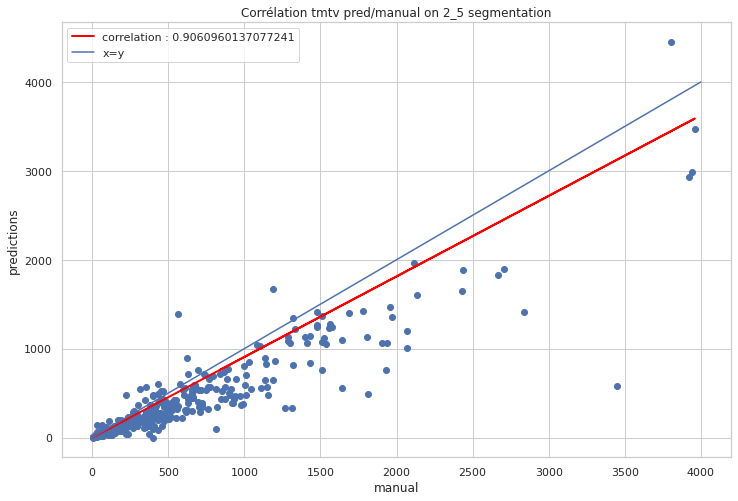

In [86]:
#2.5 
correlation = ss.pearsonr(tmtv_2_5_true, tmtv_2_5_pred)
print(correlation)
line = []
for x in tmtv_2_5_true : 
    line.append(x*correlation[0] + correlation[1])

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(tmtv_2_5_true, tmtv_2_5_pred)
plt.plot(tmtv_2_5_true, line, linewidth = 2, color='red', label='correlation : {}'.format(correlation[0]))
plt.plot([0,4000], [0,4000], label='x=y')
plt.legend(loc='upper left')
plt.xlabel('manual')
plt.ylabel('predictions')
plt.title('Corrélation tmtv pred/manual on 2_5 segmentation')

(0.9719657791448613, 7.878880273532138e-233)


Text(0.5, 1.0, 'Corrélation tmtv pred/manual on 4.0 segmentation')

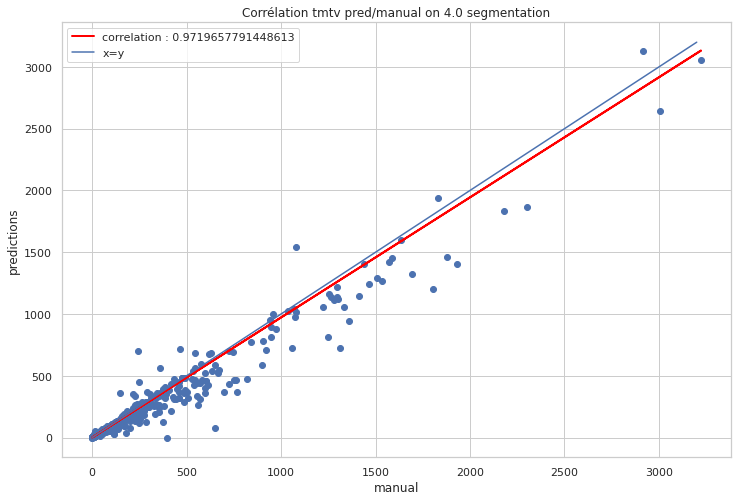

In [87]:
correlation = ss.pearsonr(tmtv_4_0_true, tmtv_4_0_pred)
print(correlation)
line = []
for x in tmtv_4_0_true : 
    line.append(x*correlation[0] + correlation[1])

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(tmtv_4_0_true, tmtv_4_0_pred)
plt.plot(tmtv_4_0_true, line, linewidth = 2, color='red', label='correlation : {}'.format(correlation[0]))
plt.plot([0,3200], [0,3200], label='x=y')
plt.legend(loc='upper left')
plt.xlabel('manual')
plt.ylabel('predictions')
plt.title('Corrélation tmtv pred/manual on 4.0 segmentation')

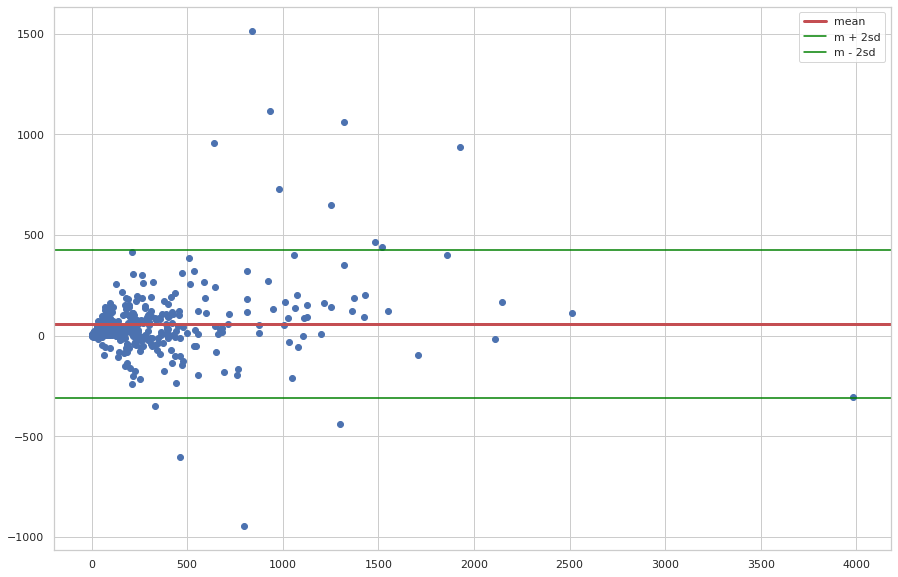

In [77]:
#BLAND ALTMAN 
#0.41 

mean = []
diff = []
for i in range(len(tmtv_0_41_true)):
    subliste = []
    subliste.append(tmtv_0_41_true[i])
    subliste.append(tmtv_0_41_pred[i])
    mean.append(np.mean(subliste))

    diff.append(tmtv_0_41_true[i] - tmtv_0_41_pred[i])
f = plt.figure(figsize=(15,10))
axes = plt.gca()
moy= np.mean(diff)
sd = np.std(diff)
plt.axhline(moy, c='r', label='mean', linewidth=3)
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.legend()
plt.scatter(mean, diff)

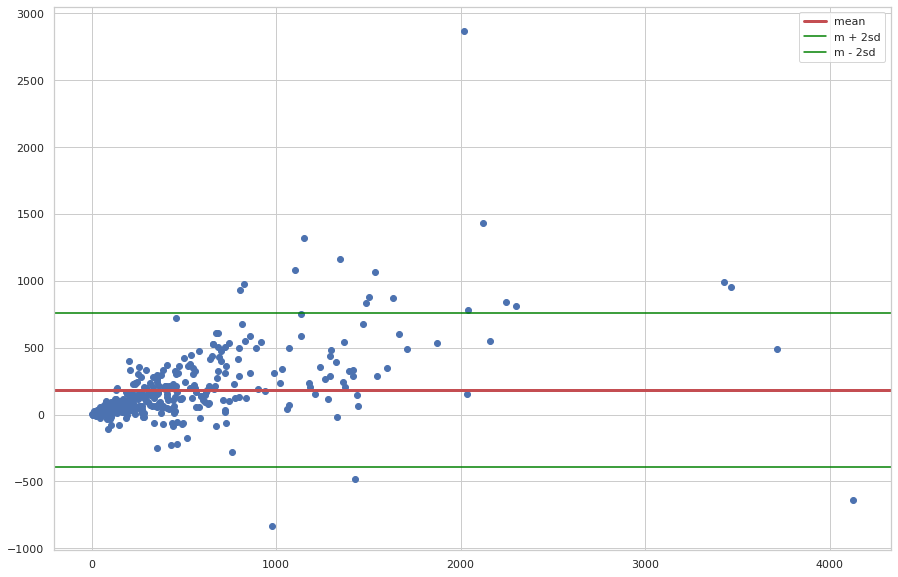

In [78]:
#2.5
mean = []
diff = []
for i in range(len(tmtv_2_5_true)):
    subliste = []
    subliste.append(tmtv_2_5_true[i])
    subliste.append(tmtv_2_5_pred[i])
    mean.append(np.mean(subliste))

    diff.append(tmtv_2_5_true[i] - tmtv_2_5_pred[i])

f = plt.figure(figsize=(15,10))
axes = plt.gca()
moy= np.mean(diff)
sd = np.std(diff)
plt.axhline(moy, c='r', label='mean', linewidth=3)
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, diff)
plt.legend()

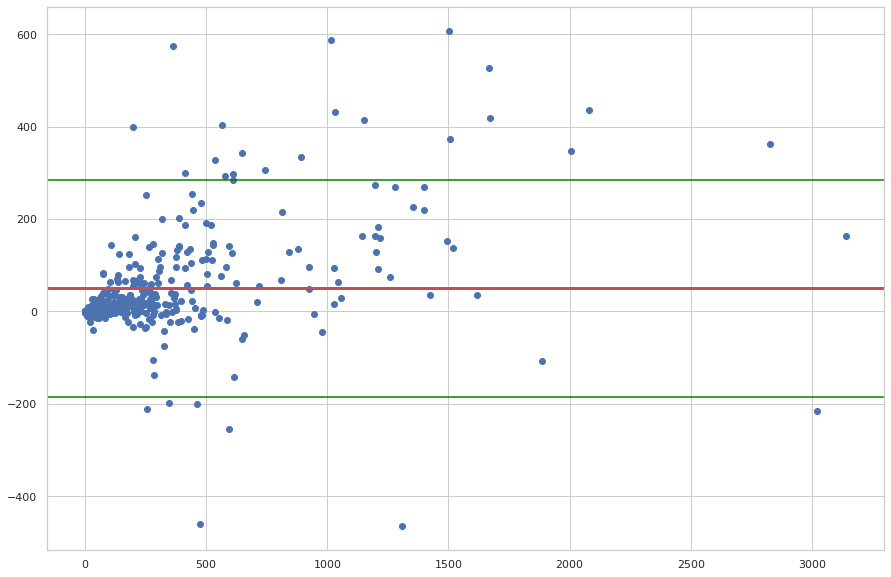

In [76]:
#4.0
mean = []
diff = []
for i in range(len(tmtv_4_0_true)):
    subliste = []
    subliste.append(tmtv_4_0_true[i])
    subliste.append(tmtv_4_0_pred[i])
    mean.append(np.mean(subliste))

    diff.append(tmtv_4_0_true[i] - tmtv_4_0_pred[i])

f = plt.figure(figsize=(15,10))
axes = plt.gca()
moy= np.mean(diff)
sd = np.std(diff)
plt.axhline(moy, c='r', label='mean', linewidth=3)
plt.axhline(moy + 2*sd, c='green', label = 'm + 2sd' )
plt.axhline(moy - 2*sd, c='green', label = 'm - 2sd' )
plt.scatter(mean, diff)
plt.legend()

In [110]:
#concardance kappa AHL 
csv_path= '/media/oncopole/DD 2To/SEGMENTATION/inference/stats/tmtv/inference_tmtv_dataset.csv'
with open(csv_path, 'r') as csv_file :
    reader = csv.reader(csv_file, delimiter = ',') #liste pour chaque ligne 
    dataset = []
    for row in reader :
        dataset.append(row)
        
del dataset[0] #enlever première ligne

ahl_true = []
ahl_pred = []
for row in dataset : 
    if 'ahl' in row : 
        ahl_pred.append(float(row[-2]))
        ahl_true.append(float(row[-1]))
print(len(ahl_pred))
print(len(ahl_true))


binary_true = []
binary_pred = []

for true in ahl_true : 
    if true < 220 : 
        binary_true.append(0)
    else : binary_true.append(1)

for pred in ahl_pred : 
    if pred < 220 : 
        binary_pred.append(0)
    else : binary_pred.append(1)

109
109


In [111]:
from sklearn.metrics import cohen_kappa_score 

score = cohen_kappa_score(binary_true, binary_pred)
print(score)

0.9247757073844031


In [ ]:
result_csv_path = '/home/oncopole/Documents/Rudy/DeepOncopole/data/vnet/dice3d_results.csv'

In [ ]:
df = pd.read_csv(result_csv_path,
                sep="\t|,",)

In [ ]:
df.info()

In [ ]:
df_train = df[df['subset']=='train'].copy()
df_val = df[df['subset']=='val'].copy()
df_test = df[df['subset']=='test'].copy()

In [ ]:
df_train.describe()

In [ ]:
df_train.median()

In [ ]:
df_val.describe()

In [ ]:
df_val.median()

In [ ]:
ax = sns.boxplot(x="subset", y="dice_cnn", data=df)
ax = sns.swarmplot(x="subset", y="dice_cnn", data=df, color=".25")

# ax.set_ylim(0.0, 1.0)
plt.show()

In [ ]:
plot_result(df_train)

In [ ]:
plot_result(df_val)

In [ ]:
plot_result(df_test)